<a href="https://colab.research.google.com/github/Draavos/making-it-rain/blob/main/EquiBind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hi there!**

This is a Jupyter notebook to perform direct-shot prediction of both the receptor binding location (blind docking) and the ligand’s bound pose and orientation using [EquiBind](https://github.com/HannesStark/EquiBind) (geometric deep learning model).

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to perform drug binding structure prediction in a cheap and yet feasible fashion.

--- 
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/Cloud-Bind/issues

**Acknowledgments**
- We would like to thank the [EquiBind](https://github.com/HannesStark/EquiBind) and [GNINA](https://github.com/gnina/gnina) team for doing an excellent job open sourcing the software.
- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).
- We would like to thank [@ruiz_moreno_aj](https://twitter.com/ruiz_moreno_aj) for his work on [Jupyter Dock](https://github.com/AngelRuizMoreno/Jupyter_Dock) 
- We would like to thank the ChemosimLab ([@ChemosimLab](https://twitter.com/ChemosimLab)) team for their incredible [ProLIF](https://prolif.readthedocs.io/en/latest/index.html#) (Protein-Ligand Interaction Fingerprints) tool.
- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.
- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.
- A Cloud-Bind by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes))

- For related notebooks see: [Cloud-Bind](https://github.com/pablo-arantes/Cloud-Bind)

In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install Cython

# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm -r Miniconda3-latest-Linux-x86_64.sh
!conda install -y -q -c conda-forge python=3.7 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge parmed  --yes 2>&1 1>/dev/null
!conda install -c bioconda pybel --yes
!conda install -c openbabel openbabel --yes
!git clone https://github.com/HannesStark/EquiBind
!pip install torch
!pip install torchvision
!pip install dgl-cu102
!pip install bio
!pip install biopandas
!pip install joblib
!pip install tensorboard
!pip install POT
!pip install pyaml
!pip install rdkit-pypi
!pip install torchani
!pip install ase
!pip install pyfiglet

#load dependencies
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import parmed as pmd
from biopandas.pdb import PandasPdb
import os
import urllib.request  
import numpy as np
import py3Dmol
from pdbfixer import PDBFixer
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors
from IPython.display import set_matplotlib_formats
import pyfiglet

In [2]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [6]:
from openmm.app.pdbfile import PDBFile
#@title **Please, provide the necessary input files below for receptor**: 
#@markdown **Important:** Run the cell to prepare your receptor.

import warnings
warnings.filterwarnings('ignore')
import os
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.PDB import is_aa
import pandas as pd
from pdbfixer import PDBFixer


# Google_Drive_Path = '/content/' #@param {type:"string"}
workDir = '/content/'

if os.path.exists(os.path.join(workDir, "name_residues_receptor.txt")):
  os.remove(os.path.join(workDir,"name_residues_receptor.txt"))
else:
  pass

receptor = os.path.join(workDir, "receptor.pdb")
ligand = os.path.join(workDir, "ligand.sdf")


Query_PDB_ID = '3HTB' #@param {type:"string"}

pdbfn = Query_PDB_ID + ".pdb"
url = 'https://files.rcsb.org/download/' + pdbfn
outfnm ='/content/rank1.pdb'

#prepare receptor
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=receptor, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

fixer = PDBFixer(filename=receptor)
fixer.removeHeterogens()
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH=7.4)
PDBFile.writeFile(fixer.topology, fixer.positions, open(receptor, 'w'))

path = '/content/'

def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"

def aa(residue):
    res = residue.id[0]
    return res != "W" 


class ResidueSelect(Select):
    def __init__(self, chain, residue):
        self.chain = chain
        self.residue = residue

    def accept_chain(self, chain):
        return chain.id == self.chain.id

    def accept_residue(self, residue):
        return residue == self.residue and aa(residue)

def extract_ligands(path):
    pdb = PDBParser().get_structure(receptor, receptor)
    io = PDBIO()
    io.set_structure(pdb)
    i2 = 1
    name_residues2 = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues2.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues_receptor.txt"), "a",))
          i2 += 1

extract_ligands(path)


dataset2 = pd.read_csv(os.path.join(workDir, 'name_residues_receptor.txt'), delimiter = " ", header=None)
df2 = pd.DataFrame(dataset2)
df2 = df2.iloc[:, [2]]
new2 = df2.to_numpy()

if os.path.exists(receptor):
  print("Successfully generated the files! :-)")
else:
  print("ERROR: Check your inputs! ")

Successfully generated the files! :-)


In [7]:
#@title **Receptor Visualization**: 
#@markdown Now the protein has been sanitized, it would be recomended to visualize and check the protein.
import py3Dmol

view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open(receptor,'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

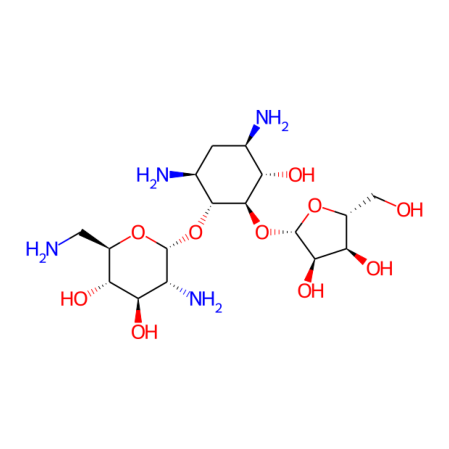

In [8]:
import requests
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
import IPython
from IPython.display import Image
import pybel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# from rdkit.Chem.Draw import IPythonConsole

#@title **Please, provide the necessary input files for the ligand**: 

#@markdown Type the name of your ligand. If you don't know the exactly name, please, check at https://pubchem.ncbi.nlm.nih.gov/
Name = 'Ribostamycin' #@param {type:"string"}


def get_cids(text):
    """
    Search pubchem and return best matching record
    """  
    url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{}/cids/TXT'.format(text)
    response = requests.get(url)
    cids = response.text.split()
    if len(cids) == 0:
        return None
    else:
        return cids
def get_record(cid):
    """
    Get pubchem record for a given cid and returns molecule as rdkit
    """
    url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{}/record/SDF'.format(cid)
    response = requests.get(url)
    mol = Chem.MolFromMolBlock(response.text)
    smi = Draw.MolToFile(mol, size=(600, 600), filename=str(Name) + '.png')
    img = mpimg.imread(str(Name) + '.png')
    plt.figure(figsize = (8,8))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    hmol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(hmol)
    hmol.GetConformer(0)
    mp = AllChem.MMFFGetMoleculeProperties(hmol)
    ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
    # Optimize
    AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
    AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
    AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
    # mol= [m for m in pybel.readfile(filename=os.path.join(workDir, "ligand.mol"), format='mol')][0]
    # out=pybel.Outputfile(filename=ligand,format='sdf',overwrite=True)
    # out.write(mol)
    # out.close()
  # return mol

def get_molecule(text, n_results=1):
    """
    Search pubchem and return best matching record
    """  
    cids = get_cids(text)
    if cids is None:
        return None
    else:
        if n_results == 1:
            return get_record(cids[0])
        else:
            return [get_record(cid) for cid in cids[:n_results]]

get_molecule(Name, n_results=1)

In [14]:
from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
import pybel
from torchani.units import HARTREE_TO_KCALMOL


#@title **Ligand geometry optimization using TorchANI**: 

#@markdown Geometry optimization for the ligand 3D structure, using ANI-1x, ANI-1ccx or ANI-2x as the optimizing engine.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/
model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand.mol")), removeHs=False)
mol = io.read(os.path.join(workDir, "ligand.mol"))
coordinates, species = mol2arr([mol_deg], device)
tensor1 = coordinates.detach().numpy()
atoms = Atoms(mol, positions=tensor1[0])
atoms.center(vacuum=3.0)
atoms.set_calculator(calculator)
print("Begin Geometry Optimization ")
opt = BFGS(atoms)
opt.run(fmax=opt_tol)
# print()
write((os.path.join(workDir, "ligand_min.xyz")), format="xyz", images=atoms)

atomic_symbols = []
xyz_coordinates = []

with open((os.path.join(workDir, "ligand_min.xyz")), "r") as file:
  for line_number,line in enumerate(file):
      if line_number == 0:
          num_atoms = int(line)
      elif line_number == 1:
          comment = line # might have useful information
      else:
          atomic_symbol, x, y, z = line.split()
          atomic_symbols.append(atomic_symbol)
          xyz_coordinates.append([float(x),float(y),float(z)])

from rdkit.Geometry import Point3D
conf = mol_deg.GetConformer()

for i in range(mol_deg.GetNumAtoms()):
  x,y,z = xyz_coordinates[i]
  conf.SetAtomPosition(i,Point3D(x,y,z))
AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "ligand_min.mol")))
AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "ligand_min.pdb")))
#convert to sdf format
mol= [m for m in pybel.readfile(filename=os.path.join(workDir, "ligand_min.mol"), format='mol')][0]
out=pybel.Outputfile(filename=ligand,format='sdf',overwrite=True)
out.write(mol)
out.close()


#TorchANI Energies
mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand_min.mol")), removeHs=False)
coordinates, species = mol2arr([mol_deg], device)
energy = model((species, coordinates)).energies
derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
force = -derivative
print('Energy:', energy.item())
# print('Force:', force.squeeze())

Model = ANI2x
Begin Geometry Optimization 
      Step     Time          Energy         fmax
BFGS:    0 08:31:20   -44600.591288        1.5068
BFGS:    1 08:31:20   -44600.788257        0.5588
BFGS:    2 08:31:20   -44600.858419        0.3934
BFGS:    3 08:31:20   -44600.925700        0.3540
BFGS:    4 08:31:20   -44600.971634        0.3393
BFGS:    5 08:31:20   -44601.004520        0.3351
BFGS:    6 08:31:20   -44601.028108        0.2572
BFGS:    7 08:31:20   -44601.044802        0.2473
BFGS:    8 08:31:20   -44601.057553        0.2293
BFGS:    9 08:31:21   -44601.069635        0.1686
BFGS:   10 08:31:21   -44601.082180        0.2110
BFGS:   11 08:31:21   -44601.094140        0.2030
BFGS:   12 08:31:21   -44601.103104        0.1492
BFGS:   13 08:31:21   -44601.109017        0.1361
BFGS:   14 08:31:21   -44601.113715        0.1198
BFGS:   15 08:31:21   -44601.118587        0.1115
BFGS:   16 08:31:21   -44601.123939        0.1066
BFGS:   17 08:31:21   -44601.129274        0.1215
BFGS:   

In [15]:
#@title **Ligand Visualization**: 
#@markdown Now the ligand has been sanitized, it would be recomended to visualize and check the ligand.

view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

# view.addModel(open(receptor,'r').read(),format='pdb')
# Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open(ligand,'r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#@title **Parameters for the EquiBind calculation:**
Output_folder_name = 'final' #@param {type:"string"}

#@markdown Explicit random seed:
seed = "0" #@param {type:"string"}

font = pyfiglet.figlet_format("EquiBind")
print(font)

docking_output = os.path.join(workDir, Output_folder_name)

# if os.path.exists(docking_output):
#   os.remove(docking_output)
# else:
#   pass

equibind = "python3 /content/EquiBind/multiligand_inference.py -o " + str(docking_output) + " -r /content/receptor.pdb -l /content/ligand.sdf --seed " + str(int(seed))

original_stdout = sys.stdout # Save a reference to the original standard output
with open('equibind.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(equibind)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 equibind.sh 2>&1 1>/dev/null
!bash equibind.sh

import gzip
v = py3Dmol.view()
v.setViewStyle({'style':'outline','color':'black','width':0.05})
v.addModel(open(receptor).read())
v.setStyle({'cartoon':{},'stick':{'colorscheme':'white','radius':.1}})
# v.addModel(open(res_box).read())
# v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.175}})
v.addModelsAsFrames(open(os.path.join(workDir, Output_folder_name + "/output.sdf")).read())
v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon'}})
v.zoomTo({'model':1})
v.rotate(90)

In [ ]:
#@title **Download your results**
from google.colab import files
import shutil

if os.path.exists(os.path.join(workDir, "sample_data")):
  shutil.rmtree(os.path.join(workDir, "sample_data"))
else:
  pass

if os.path.exists(os.path.join(workDir, "results_EquiBind.zip")):
  os.remove(os.path.join(workDir, "results_EquiBind.zip"))
else:
  pass

!zip -FSr "results_EquiBind.zip" "/content/" -x "/content/EquiBind/*" 2>&1 1>/dev/null
files.download('results_EquiBind.zip')